# Networks in Python

In this notebook we'll explore using `networkx` to represent networks in Python. We'll see how to create networks in different ways, how to manipulate them, and develop an algorithm that extracts the degree distribution and plots it.

We assume some familiarity with [`matplotlib`](https://matplotlib.org/stable/index.html), but most of the code should hopefully be fairly self-explanatory. There are some links to `matplotlib` material in the reading list.

In [1]:
# network representation
import networkx

# maths support
import numpy

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## Building a network by hand

We've noted before that the words "network" and "graph" are used quite interchangeably in network science, and `networkx` is no different: it uses the word "graph" a lot (despite using the word "network" in its title...).

We'll first create an empty network:

In [2]:
g1 = networkx.Graph()

This gives us a network with no nodes and no edges. Both nodes and edges are accessible in dictionaries `nodes` and `edges` respectively, so we can easily check that the network in fact has no nodes:

In [3]:
len(g1.nodes()) == 0

True

And therefore, of course, no edges.

In [4]:
len(g1.edges()) == 0

True

The next step is probably to add some nodes and edges. We can do this in several ways, the simplest being to simply add edges between node labels:

In [5]:
g1.add_edges_from([(0, 1), (1, 2), (1, 3), (1, 4), (3, 4)])

This implicitly adds nodes with the given labels:

In [6]:
list(g1.nodes())

[0, 1, 2, 3, 4]

(I could have used pretty much any object as a node label, for example a string.) You'll recognise this as an **edge list** representation for a network: a list of edges with the node labels being extracted implicitly. The node labels all need to be distinct. We're expecting there to be five nodes in the network now.

In [8]:
len(g1.nodes())

5

Let's see what this network looks like. To do this we'll use `matplotlib` to create a figure and some axes, and then let `networkx` decide how to draw the network.

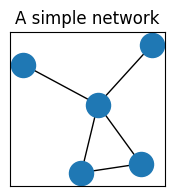

In [9]:
# create a figure
fig = plt.figure(figsize=(2, 2))

# retrieve the main axes
ax = fig.gca()

# draw the network
networkx.draw_networkx(g1,                # the network to draw
                       ax=ax,             # the axes to draw into
                       with_labels=False) # don't draw the node labels

# fill in the title
ax.set_title('A simple network')
plt.show()

If we want to node labels, we can have `networkx` add them in.

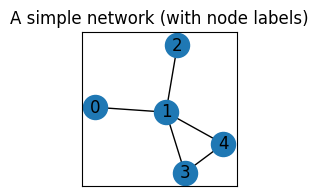

In [11]:
fig = plt.figure(figsize=(2, 2))
ax = fig.gca()

# draw the network
networkx.draw_networkx(g1, ax=ax)   # or use with_labels=True

ax.set_title('A simple network (with node labels)')
plt.show()

Wait! -- these two networks look different, even though all we did was ask for the labels to be added! That's because a graph has **topology** but no inherent **geometry**, so `networkx` is at liberty to lay the nodes out in space in a number of different ways. The choice of where to put nodes is called a *layout*, and by default `networkx` uses a layout that can put nodes in different places each time it's called: we'll see other layouts later. The important thing is, if you look at the edges in both figures (for example the little triangle of nodes), they're the same: the topology has been retained, even though the geometry of the drawing has changed.

A network is an object, so we can also add new nodes and edges. Let's add a node.

In [12]:
g1.add_node(6)

Drawing the network again yields a new picture.

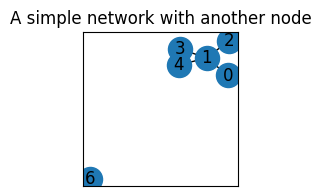

In [13]:
fig = plt.figure(figsize=(2, 2))
ax = fig.gca()

# draw the network
networkx.draw_networkx(g1, ax=ax)

ax.set_title('A simple network with another node')
plt.show()

Again, `networkx` has chosen a layout that's not entirely clear, but we can see that the new node isn't connected to any other nodes, as we'd expect. We can change that by adding an edge and drawing again.

In [14]:
g1.add_edge(6, 0)

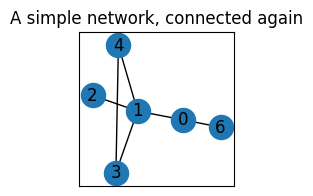

In [15]:
fig = plt.figure(figsize=(2, 2))
ax = fig.gca()

# draw the network
networkx.draw_networkx(g1, ax=ax)

ax.set_title('A simple network, connected again')
plt.show()

There are other ways of adding nodes and edges, explained in the [`networkx` documentation](https://networkx.org/documentation/stable/reference/classes/index.html).

## Attributes on nodes (and edges)

`networkx` lets us get at the nodes (and edges) in a network through the `nodes` dict.

In [16]:
for i in g1.nodes():
    print(i, g1.nodes[i])

0 {}
1 {}
2 {}
3 {}
4 {}
6 {}


You'll notice that each element in this dict also seems to be a dict, and this is indeed the case. It's often useful to be able to remember more information about nodes and edges than just their label, and so each node (and edge) in `networkx` has an **attributes** dict associated with it into which you can add bindings just like any other dict. For example, let's suppose the node labelled 6 represents a person called Bob. We can add a key "name" to the node's attributes with a value of "Bob" to record this.

In [17]:
g1.nodes[6]['name'] = 'Bob'

In [18]:
for i in g1.nodes():
    print(i, g1.nodes[i])

0 {}
1 {}
2 {}
3 {}
4 {}
6 {'name': 'Bob'}


The same approach works for edges. (We'll let you work out how: try looking at the documentation for the [`Graph` class](https://networkx.org/documentation/stable/reference/classes/graph.html) to learn more.) Remember, the attributes are different to the node labels: labels must be unique in a given network, whereas attributes are unconstrained.

## Navigating the network

Suppose we now want to navigate the network, for example starting at a node and finding all its **neighbours**, the nodes to which it directly has an edge. `networkx` in fact makes this trivially easy: we simply index the network object itself (rather than its `nodes` dict) with the label of the node we're interested in, and get back a list of that node's neighbours.

In [19]:
list(g1[6])

[0]

In [20]:
list(g1[1])

[0, 2, 3, 4]

(Be careful of the syntax here: `g1[1]` is the *neighbourhood* of 1 in `g1`. If you want to get at the *attributes* of 1, you should use `g1.nodes[1]`.)

We can of course traverse the set of all nodes in the network and retrieve their neighbourhoods.

In [21]:
for i in g1.nodes():
    print(i, list(g1[i]))

0 [1, 6]
1 [0, 2, 3, 4]
2 [1]
3 [1, 4]
4 [1, 3]
6 [0]


You can use this information to traverse the network, starting from a node and visiting its neighbours, then their neighbours, then *their* neighbours, and so on. We'll look at this approach &ndash; and the problems it can lead to when building algorithms! &ndash; later.

## The adjacency matrix

For some operations, this neighbnbourhood-based representation is fine. For others, it's not so good. A common alternative is the **adjacency matrix**. The adjacency matrix for a network with $N$ edges is an $N \times N$ matrix $\mathbf{A}$ where, for nodes $i$ and $j$, the value of $A_{ij}$ is 1 is the nodes are adjacent and 0 otrherwise.

In [22]:
m1 = networkx.adjacency_matrix(g1)

In [23]:
m1

<6x6 sparse array of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

The matrix that's returnbed is a **sparse matrix**: an unusual data structure That's not very useful, but it makes sense if you think about it: in a network, most nodes aren't adjacent to each other, so most of the entries in the adjacency matrix will be zero. A sparse matrix is simply a data structure that make use of this fact to use less memory when representing large matrices. Normally we'd leave the matrix sparse, but for small examples (like this) we can make it dense so we can visualise it.

In [24]:
a1 = m1.toarray()
a1

array([[0, 1, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0]])

Now you may be wondering at this point what $i$ and $j$ are when we said earlier that we can use *any object* as a node label. `networkx` maintains a **canonical ordering** of the nodes in the network &ndash; actually the order in which they appear in the `nodes` dict (which is actually an *ordered* dict). So you can find the *index* of a node by finding its *position* in this dict.

For example, let's find the index of the nodes we labelled 0 and 6 above.

In [25]:
list(g1.nodes()).index(0), list(g1.nodes()).index(6)

(0, 5)

So the node labelled 6 is actually index 5. We can now test whether nodes 0 and 6 are adjacent by testing the appropriate element of the adjacency matrix.

In [26]:
a1[0][5]

1

This indicates they are adjacent: the corresponding element of the adjacency matrix is 1. Of course there are many other weays to accomplish the same thing. We might, for example, grab the neighbourhood of one node and see if it contains the other.

In [27]:
0 in g1[6]

True

The thing to remember is that Python typically provides lots of *different* ways to accomplish the *same* thing, so that you can choose the one that's most natural in trhe circumstances in which you find yourself.

## Using a generator function

This way of building networks is straightforward, but a lot of the time we might want to build really big networks, or have a quite complicated topology or build process. Sometimes it makes sense to write our own functions to do this, but lots of "standard" networks have **generators** built-in to `networkx`. You can find lots of examples in the [graph generators documentation](https://networkx.org/documentation/stable/reference/generators.html).

For example, suppose we want to create a balanced tree with a given arity and depth. Let's try a binary tree (arity 2) with height 4.

In [28]:
r = 2    # arity
h = 4    # height

g2 = networkx.balanced_tree(r, h)

We can visualise this network by drawing it as before.

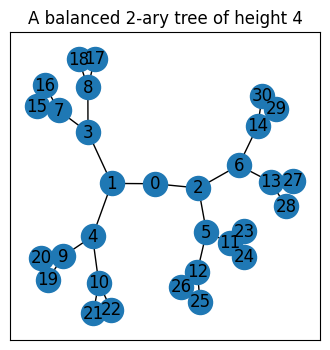

In [29]:
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()

# draw the network
networkx.draw_networkx(g2, ax=ax)

ax.set_title(f'A balanced {r}-ary tree of height {h}')
plt.show()

Hmmmm.... OK, this looks *kind of* like we'd expect, but it's really not great as a layout. Perhaps we should explore layouts that make a better job than the default.

## Picking a layout

The good news is that `networkx` has lots of layout algorithms: you can find them in the [drawing algorithms documentation](https://networkx.org/documentation/stable/reference/drawing.html). The bad news is that there may not be *any* layout that well-suited to showing you the network you have, and it's often a matter of trial and error to see which of the options works &ndash; and if *none* of them work for you, you might end up writing your own.

Let's try drawing the tree with one of the other layouts in the library.

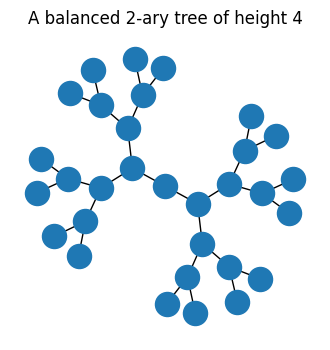

In [30]:
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()

# draw the network
networkx.draw_kamada_kawai(g2, ax=ax)

ax.set_title(f'A balanced {r}-ary tree of height {h}')
plt.show()

That's significantly better: clearly tree-like, although not laid-out in the manner that computer scientists usually use. It turns out there isn't a layout algorithm for that built-in to `netwoikx`:  we'd need to write our own if we wanted it badly enough.

## Larger example: The degree distribution of an Erd&#337;s-R&eacute;nyi network

Finally, let's move up the scale and use a generator for a useful type of network, the Erd&#337;s-R&eacute;nyi  (ER) network. When we talked about these networks we said that they have a Poisson degree distribution, the discrete analogue of the bell-curved  Normal distribution. Let's create one of these networks and check this assertion out computationally.

`networkx` has a generator for ER networks &ndash; although is helps to know that they're also known as "$G_{Np}$-random graphs". With this information to hand, we can provide the necessary information to the right function.

In [31]:
# network parameters
N = 1000
kmean = 5

# compute the occupation probability (needed by the generator)
phi = kmean / N

# build the network
g3 = networkx.fast_gnp_random_graph(N, phi)

Remember, an ER network is characterised by the number $N$ of nodes it has and *one or other of* the mean degree of nodes $\langle k \rangle$ *or* the probability $\phi$ of an edge existing between each pair of nodes, with the two optional parameters being related by

$$
\phi = \frac{\langle k \rangle}{N}
$$

So we computed $\phi$ from $\langle k \rangle$ using this relationship.

We can draw this network using the functions we used above.

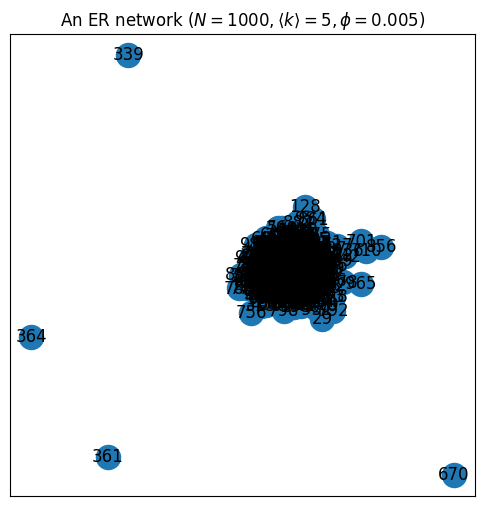

In [32]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# draw the network
networkx.draw_networkx(g3, ax=ax)

ax.set_title(f'An ER network ($N={N}, \\langle k \\rangle={kmean}, \phi={phi}$)')
plt.show()

...and a problem immediately becomes apparent. The network is too big to draw like this, even though it's "only" got 1000 nodes. Clearly drawing large networks only has limited usability. There are other approaches, for example just plotting the nodes without the edges, and making things a bit smaller.

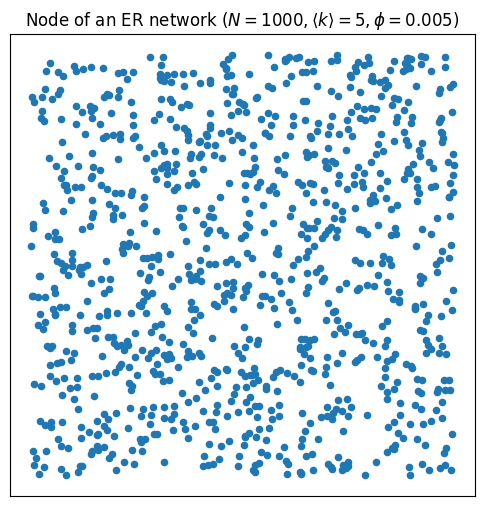

In [33]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# draw the network
networkx.draw_networkx_nodes(g3, ax=ax,
                             pos=networkx.random_layout(g3),  # lay the nodes out randomly
                             node_size=20)                    # small dots (so they fit)

ax.set_title(f'Node of an ER network ($N={N}, \\langle k \\rangle={kmean}, \phi={phi}$)')
plt.show()

Still uninformative &ndash; and imagine what it would be like with the edges drawn too. There are better ways than this simple approach, of course, but it's still the case that it's hard to extract much information visually. That's why we typically don't draw networks like this when analysing them. Instead we'll derive information from the network computationally, and plot this information instead of the "raw" network.

Let's do this for the degree distribution. Remember, the degree distribution is the fraction of nodes that have a given number of neighbours, or degree. To work out this out we need to perform three steps:

1. Extract the neighbourhoods of the nodes
2. Count their sizes, since we only care about *how many* neighbours there are
3. Put the sizes into bins so we get the number of nodes with a given degree

`networkx` gives us a function for extracting the degree of a network.

In [34]:
ks = list(dict(networkx.degree(g3)).values())

The `dict(networkx.degree(g3))` routine creates a dict from node to degree, from which we extract the values (the degrees), throwing away the node identities.

We then need to "bin" these values. The `numpy` library happens to have the function we need: [`unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), which can extract the unique elements of a list and also compute the number of each element there is. It actually returns a tuple of information that `matplotlib` can use directly. Since we know what the mean degree *should* be, we can plot that too to see whether the reality matches what the theory says.

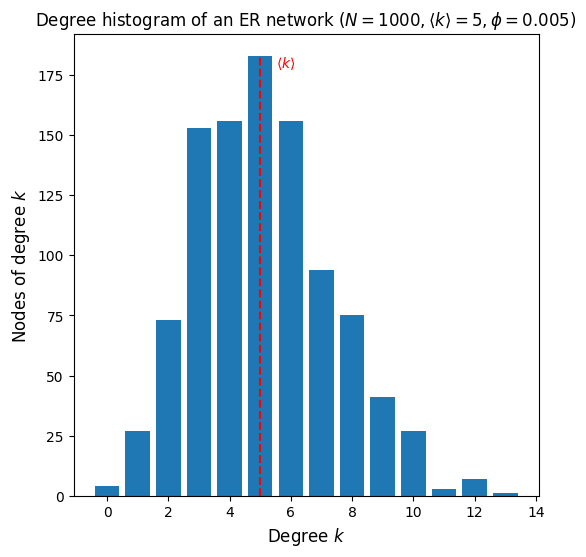

In [35]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# draw the degree histogram
binned = numpy.unique(ks, return_counts=True)
ax.bar(*binned)

# draw in the expected kmean
ax.plot([kmean, kmean], [0, max(binned[1])],    # the largest of the bins
        'r--')
ax.annotate(f'$\\langle k \\rangle$',           # label for mean degree
            (kmean + 0.5, max(binned[1] - 5)),  # positioned just off the line
            color='r')

# fill in the title and axis labels
ax.set_title(f'Degree histogram of an ER network ($N={N}, \\langle k \\rangle={kmean}, \phi={phi}$)')
ax.set_xlabel('Degree $k$')
ax.set_ylabel('Nodes of degree $k$')
plt.show()

Remember to add a title and axis labels to any plots, and to any features that you want to highlight: it makes everything easier to understand for a reader.

## Summary

In this notebook we've looked at how `networkx` can be used to represent networks, and how `matplotlib` can be used to draw them. We've also discovered that just drawing networks is only of limited utility, and we'll probably spend more time plotting information extracted from networks (or from simulations over them).

`networkx` is a huge package with lots of built-in capabilities: far more than it makes sense to explore in a notebook like this. It takes time to learn, and the best way is just to start to answer some questions with it, and look up the functions as you go: as a general rule, if you find something that you think *should* be built-in, there's a good chance that it is. This lets you make good use of the library's code and focus on only writing the code that's unique to your application.